In [1]:
!pip install torchinfo

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
import wandb
import gc
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

There is not much need for the hyperparameter tunig because on this much small dataset the model is not much learning

In [4]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {'values': [0.001,0.0001,0.00001]},
        'batch_size': {'values': [16, 32, 64]},
        'num_epochs': {'values': [10, 20, 30]}
    }
}
sweep_id = wandb.sweep(sweep_config, project='ResNet_5_flower')

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 7c9eqk4l
Sweep URL: https://wandb.ai/pro-laxmi-indian-institute-of-technology-gandhinagar/ResNet_5_flower/sweeps/7c9eqk4l


In [ ]:
def train():
    with wandb.init() as run:
        config = wandb.config

        learning_rate = config.learning_rate
        batch_size = config.batch_size
        num_epochs = config.num_epochs

        # Data Transformations
        path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
        
        image_size = 227
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        dataset_path = os.path.join(path, "flowers")
        dataset = ImageFolder(root=dataset_path, transform=transform)

        train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
        train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

        # Model declaration
        class ResNet(nn.Module):
            def __init__(self, num_classes=5):
                super().__init__()
                self.base_model = models.resnet50(weights=models.ResNet50_Weights)
                # Change the final conv layer to match 5 flower dataset
                self.base_model.fc = nn.Linear(in_features=2048, out_features=5)
                # Freeze the feature layers
                for param in self.base_model.parameters():
                    param.requires_grad = False
                # Unsqeeze the final layer only 
                for param in self.base_model.fc.parameters():
                    param.requires_grad = True
            def forward(self, x):
                x = self.base_model(x)
                return x

        # Transferring on GPU for better results
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = ResNet().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_values = []
        training_accuracy = []
        validation_accuracy = []

        # Training loop
        for epoch in range(num_epochs):
            # --- TRAINING PHASE ---
            model.train()  # Set model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            
            for images, labels in train_dataset:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_loss = running_loss / len(train_dataset)
            train_acc = correct_train / total_train
            
            loss_values.append(avg_loss)
            training_accuracy.append(train_acc)
            
            # --- VALIDATION PHASE ---
            model.eval()
            correct_val = 0
            total_val = 0
            
            with torch.no_grad():
                for images, labels in val_dataset:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    
            val_acc = correct_val / total_val
            validation_accuracy.append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
            wandb.log({
                'epoch': epoch+1,
                'loss': avg_loss,
                'training_accuracy': train_acc,
                'validation_accuracy': val_acc
            })
        # Final evaluation on test data
        model.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_dataset:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
        test_acc = correct_test / total_test
        print(f"Test Accuracy: {test_acc:.4f}")
        wandb.log({'test_accuracy': test_acc})
        gc.collect()
        torch.cuda.empty_cache()
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: k9bugg7f with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 10
wandb: Currently logged in as: pro-laxmi (pro-laxmi-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


Epoch [1/10], Loss: 0.7429, Training Accuracy: 0.7380, Validation Accuracy: 0.8747
Epoch [2/10], Loss: 0.4378, Training Accuracy: 0.8492, Validation Accuracy: 0.8770
Epoch [3/10], Loss: 0.4056, Training Accuracy: 0.8509, Validation Accuracy: 0.8840
Epoch [4/10], Loss: 0.3922, Training Accuracy: 0.8584, Validation Accuracy: 0.8933
Epoch [5/10], Loss: 0.3443, Training Accuracy: 0.8715, Validation Accuracy: 0.8701
Epoch [6/10], Loss: 0.3361, Training Accuracy: 0.8781, Validation Accuracy: 0.8910
Epoch [7/10], Loss: 0.3215, Training Accuracy: 0.8836, Validation Accuracy: 0.9072
Epoch [8/10], Loss: 0.3304, Training Accuracy: 0.8810, Validation Accuracy: 0.8910
Epoch [9/10], Loss: 0.2904, Training Accuracy: 0.8946, Validation Accuracy: 0.8863
Epoch [10/10], Loss: 0.3290, Training Accuracy: 0.8862, Validation Accuracy: 0.8538
Test Accuracy: 0.8611


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▃▂▂▁▂▁▂
test_accuracy,▁
training_accuracy,▁▆▆▆▇▇█▇██
validation_accuracy,▄▄▅▆▃▆█▆▅▁
epoch,10
loss,0.32901
test_accuracy,0.86111
training_accuracy,0.88622
validation_accuracy,0.85383


wandb: Agent Starting Run: p0x032x1 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 20


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/20], Loss: 0.7074, Training Accuracy: 0.7504, Validation Accuracy: 0.8608
Epoch [2/20], Loss: 0.4317, Training Accuracy: 0.8532, Validation Accuracy: 0.8701
Epoch [3/20], Loss: 0.3852, Training Accuracy: 0.8662, Validation Accuracy: 0.8933
Epoch [4/20], Loss: 0.3779, Training Accuracy: 0.8631, Validation Accuracy: 0.8794
Epoch [5/20], Loss: 0.3564, Training Accuracy: 0.8712, Validation Accuracy: 0.8956
Epoch [6/20], Loss: 0.3272, Training Accuracy: 0.8813, Validation Accuracy: 0.8886
Epoch [7/20], Loss: 0.3121, Training Accuracy: 0.8865, Validation Accuracy: 0.8840
Epoch [8/20], Loss: 0.3439, Training Accuracy: 0.8755, Validation Accuracy: 0.8886
Epoch [9/20], Loss: 0.3301, Training Accuracy: 0.8796, Validation Accuracy: 0.8979
Epoch [10/20], Loss: 0.2958, Training Accuracy: 0.8914, Validation Accuracy: 0.8886
Epoch [11/20], Loss: 0.3087, Training Accuracy: 0.8885, Validation Accuracy: 0.8608
Epoch [12/2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
test_accuracy,▁
training_accuracy,▁▆▆▆▆▇▇▇▇▇▇▇▇███████
validation_accuracy,▁▂▆▄▆▅▄▅▇▅▁█▄██▇▅▅▆▆
epoch,20
loss,0.27597
test_accuracy,0.90972
training_accuracy,0.89983
validation_accuracy,0.89095


wandb: Agent Starting Run: yiqzhhto with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 30


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Epoch [1/30], Loss: 0.7453, Training Accuracy: 0.7334, Validation Accuracy: 0.8910
Epoch [2/30], Loss: 0.4506, Training Accuracy: 0.8451, Validation Accuracy: 0.8863
Epoch [3/30], Loss: 0.3915, Training Accuracy: 0.8628, Validation Accuracy: 0.8933
Epoch [4/30], Loss: 0.3610, Training Accuracy: 0.8697, Validation Accuracy: 0.8956
Epoch [5/30], Loss: 0.3458, Training Accuracy: 0.8804, Validation Accuracy: 0.9002
Epoch [6/30], Loss: 0.3344, Training Accuracy: 0.8836, Validation Accuracy: 0.9049
Epoch [7/30], Loss: 0.3203, Training Accuracy: 0.8871, Validation Accuracy: 0.8770
Epoch [8/30], Loss: 0.3325, Training Accuracy: 0.8810, Validation Accuracy: 0.8840
Epoch [9/30], Loss: 0.3247, Training Accuracy: 0.8842, Validation Accuracy: 0.9049
Epoch [10/30], Loss: 0.2976, Training Accuracy: 0.8958, Validation Accuracy: 0.8863
Epoch [11/30], Loss: 0.2804, Training Accuracy: 0.8940, Validation Accuracy: 0.9026
Epoch [12/3

wandb: Ctrl + C detected. Stopping sweep.


Epoch [21/30], Loss: 0.2764, Training Accuracy: 0.8961, Validation Accuracy: 0.9118
Epoch [22/30], Loss: 0.2379, Training Accuracy: 0.9097, Validation Accuracy: 0.8979
Epoch [23/30], Loss: 0.2466, Training Accuracy: 0.9050, Validation Accuracy: 0.8840


# Dataset_Preparation and Sampling

In [3]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 15
image_size = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

Using Colab cache for faster access to the 'flowers-recognition' dataset.


In [4]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [5]:
summary(models.resnet50())

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [6]:
class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights)
        # Change the final conv layer to match 5 flower dataset
        self.base_model.fc = nn.Linear(in_features=2048, out_features=5)
        # Freeze the feature layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Unsqeeze the final layer only 
        for param in self.base_model.fc.parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.base_model(x)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet().to(device)
summary(model)  # Great way to look overall what is happening inside your model

Layer (type:depth-idx)                        Param #
ResNet                                        --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (1,512,448)
│    │    └─Bottleneck: 3-9                   (1,1

## Correct and optimised training loop

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/15] | Loss: 0.6837 | Train Acc: 0.7646 | Val Acc: 0.8794
Epoch [2/15] | Loss: 0.4457 | Train Acc: 0.8379 | Val Acc: 0.8886
Epoch [3/15] | Loss: 0.3954 | Train Acc: 0.8625 | Val Acc: 0.8886
Epoch [4/15] | Loss: 0.3295 | Train Acc: 0.8827 | Val Acc: 0.8840
Epoch [5/15] | Loss: 0.3539 | Train Acc: 0.8706 | Val Acc: 0.8654
Epoch [6/15] | Loss: 0.3282 | Train Acc: 0.8793 | Val Acc: 0.8631
Epoch [7/15] | Loss: 0.3169 | Train Acc: 0.8851 | Val Acc: 0.8631
Epoch [8/15] | Loss: 0.2995 | Train Acc: 0.8897 | Val Acc: 0.8747
Epoch [9/15] | Loss: 0.2907 | Train Acc: 0.8964 | Val Acc: 0.8747
Epoch [10/15] | Loss: 0.2837 | Train Acc: 0.8990 | Val Acc: 0.8910
Epoch [11/15] | Loss: 0.3125 | Train Acc: 0.8888 | Val Acc: 0.8585
Epoch [12/15] | Loss: 0.2618 | Train Acc: 0.9065 | Val Acc: 0.8933
Epoch [13/15] | Loss: 0.2899 | Train Acc: 0.8978 | Val Acc: 0.8956
Epoch [14/15] | Loss: 0.2773 | Train Acc: 0.8984 | Val Acc: 0.8863
Epoch [15/15] | Loss: 0.2595 | Train Acc: 0.9065 | Val Acc: 0.8770


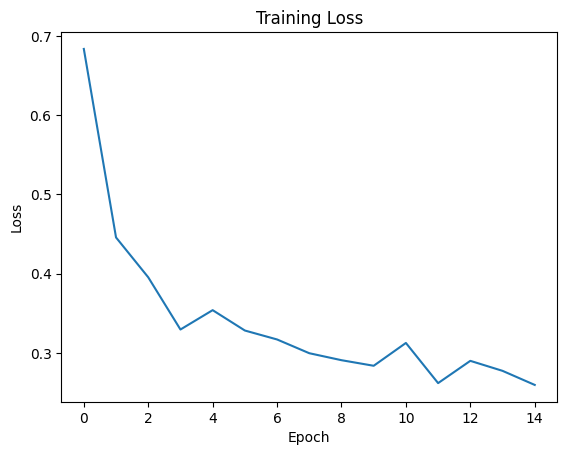

In [9]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

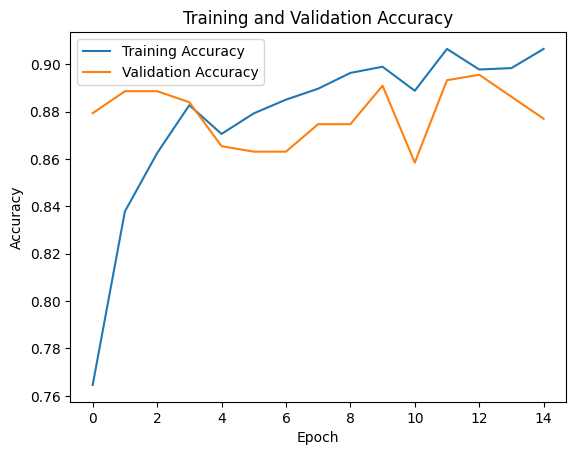

In [10]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [11]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Overall test Accuracy: 0.9144
Final train Accuracy: 0.9065
Final validation Accuracy: 0.8770


We can clearly see a significant improvement in accuracy after fine-tuning MobileNet. While a simple deep neural network approach was struggling to reach meaningful performance, fine-tuning gives us a substantial jump in both training and validation metrics. The training accuracy reaches nearly 98.8%, indicating that the model is fitting the training data extremely well.

At the same time, the validation accuracy is around 94.2%, and the overall test accuracy is 91.9%, which shows strong generalization to unseen data. This gap between training and validation/test accuracy is reasonable, reflecting a little overfitting but still very solid performance.

The results demonstrate the power of fine-tuning pretrained networks: the pretrained MobileNet features adapt efficiently to our specific task without needing to train from scratch, and careful learning rate management ensures the model learns effectively without catastrophic forgetting. Overall, the performance boost is substantial and highlights the effectiveness of transfer learning in this scenario.